<h1> Testing PASTIS in imaging mode </h1>

Here we're testing the module "image_pastis.py" which is the version of PASTIS that still generates images. Since this is a module, it's a tiny bit harder to test, so I'm basically just going through the code step by step.

In [1]:
import os
import numpy as np
from astropy.io import fits
import poppy.zernike as zern
import poppy.matrixDFT as mft
import poppy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

os.chdir('../python/')
from config import CONFIG_INI
import util_pastis as util

# Change to output folder for this script
dir = '/Users/ilaginja/Documents/data_from_repos/pastis_data/calibration'
os.chdir(dir)

In [23]:
# Define some useful random functions

# This one is copied from util_pastis and could just as well be used as util.zoom_cen().
def zoom(im, bb):
    """
    Cut out a square box from the image center with half-box size bb.
    :param im: image from which box will be taken
    :param bb: half-box size
    :return:
    """
    x = int(im.shape[1]/2)
    y = int(im.shape[0]/2)
    return(im[y-bb:y+bb, x-bb:x+bb])

## Setup and single segment aberration

Since this is a module, its function will be called with input parameters, which I will define separetaly here to be able to use them.

In [2]:
# Define the aberration coeffitients "coef"
nb_seg = CONFIG_INI.getint('telescope', 'nb_subapertures')
zern_max = CONFIG_INI.getint('zernikes', 'max_zern')

nm_aber = CONFIG_INI.getfloat('calibration', 'single_aberration_nm')    # [nm] amplitude of aberration
zern_number = CONFIG_INI.getint('calibration', 'zernike')               # Which (Noll) Zernike we are calibrating for
wss_zern_nb = util.noll_to_wss(zern_number)                             # Convert from Noll to WSS framework


### What segmend are we aberrating? ###
i = 0   # segment 1 --> i=0, seg 2 --> i=1, etc.
### ------------------------------- ###

# Create arrays to hold Zernike aberration coefficients
Aber_WSS = np.zeros([nb_seg, zern_max])           # The Zernikes here will be filled in the WSS order!!!
                                                  # Because it goes into _apply_hexikes_to_seg().
Aber_Noll = np.copy(Aber_WSS)                     # This is the Noll version for later.

# Feed the aberration nm_aber into the array position
# that corresponds to the correct Zernike, but only on segment i
Aber_WSS[i, wss_zern_nb-1] = nm_aber / 1e9        # Aberration on the segment we're currenlty working on;
                                                  # convert to meters; -1 on the Zernike because Python starts
                                                  # numbering at 0.
Aber_Noll[i, zern_number-1] = nm_aber             # Noll version - in nm!

# Vector of aberration coefficients takes all segments, but only for the Zernike we currently work with
coef = Aber_Noll[:,zern_number-1]

# Define the (Noll) zernike number
zernike_pol = zern_number

# We're not calibrating
cali=False

print('coef:', coef)
print('Zernike (Noll):', util.zernike_name(zern_number, framework='Noll'))
print('Zernike (WSS):', util.zernike_name(wss_zern_nb, framework='WSS'))
print('Zernike number (Noll):', zernike_pol)

coef: [ 100.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.]
Zernike (Noll): piston
Zernike (WSS): piston
Zernike number (Noll): 1


Now we'll start with the actual code in the module function.

Pupil shape: (1024, 1024)


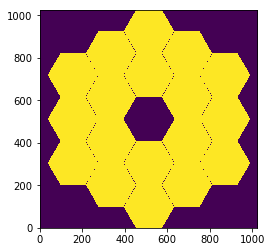

In [30]:
#-# Parameters
dataDir = CONFIG_INI.get('local', 'local_data_path')
nb_seg = CONFIG_INI.getint('telescope', 'nb_subapertures')
tel_size_m = CONFIG_INI.getfloat('telescope', 'diameter')
real_size_seg = CONFIG_INI.getfloat('telescope', 'flat_to_flat')   # size in meters of an individual segment flatl to flat
size_seg = CONFIG_INI.getint('numerical', 'size_seg')              # pixel size of an individual segment tip to tip
wvln = CONFIG_INI.getint('filter', 'lambda')
inner_wa = CONFIG_INI.getint('coronagraph', 'IWA')
outer_wa = CONFIG_INI.getint('coronagraph', 'OWA')
tel_size_px = CONFIG_INI.getint('numerical', 'tel_size_px')        # pupil diameter of telescope in pixels
im_size_pastis = CONFIG_INI.getint('numerical', 'im_size_px_pastis')   # image array size in px
im_size_e2e = CONFIG_INI.getint('numerical', 'im_size_px_webbpsf')
sampling = CONFIG_INI.getfloat('numerical', 'sampling')            # sampling
largeur = tel_size_px * sampling                                   # size of pupil (?) with taking the sampling into account
size_px_tel = tel_size_m / tel_size_px                             # size of one pixel in pupil plane in m
px_sq_to_rad = size_px_tel * np.pi / tel_size_m
zern_max = CONFIG_INI.getint('zernikes', 'max_zern')
    
# Create Zernike mode object for easier handling
zern_mode = util.ZernikeMode(zernike_pol)

#-# Mean subtraction for piston
if zernike_pol == 1:
    coef -= np.mean(coef)

#-# Generic segment shapes
# Load pupil from file
pupil = fits.getdata(os.path.join(dataDir, 'segmentation', 'pupil.fits'))
pup_im = np.copy(pupil)

print('Pupil shape:', pupil.shape)

plt.imshow(pupil, origin='lower')
plt.show()

### Creating a mini segment

At this point, you have to make sure the pixel size  **size_seg** of your individual segment is correct, and this will be different depending on the pixel size of your total pupil.

With that, we create a mini segment.

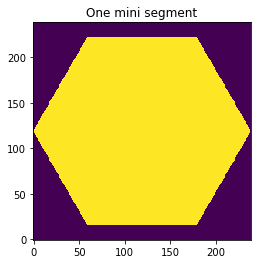

Mini-segment array size: (239, 239)


In [13]:
# Creat a mini-segment (one individual segment from the segmented aperture)
mini_seg_real = poppy.NgonAperture(name='mini', radius=real_size_seg)   # creating real mini segment shape with poppy
#test = mini_seg_real.sample(wavelength=wvln, grid_size=flat_diam, return_scale=True)   # fix its sampling with wavelength
mini_hdu = mini_seg_real.to_fits(wavelength=wvln, npix=size_seg)    # make it a fits file
mini_seg = mini_hdu[0].data 

plt.imshow(mini_seg, origin='lower')
plt.title('One mini segment')
plt.show()

print('Mini-segment array size:', mini_seg.shape)

We managed to cut the array to a square where the mini-segment is just about touching the array edges. The size of this array is the size of our mini-segment and that's a number that we have to enter into the configfile. Enter the pixel size of the mini-segment array into the configfile section: **[numerical] --> size_seg**

### Generating the dark hole

DH array shape: (1024, 1024)


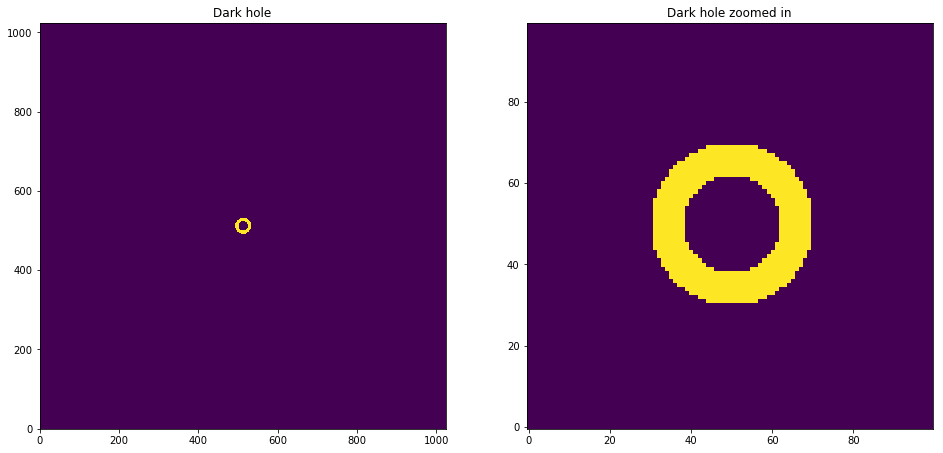

In [24]:
#-# Generate a dark hole
dh_area = util.create_dark_hole(pup_im, inner_wa, outer_wa, sampling)
print('DH array shape:', dh_area.shape)

boxsize = 50
    
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(dh_area, origin='lower')
plt.title('Dark hole')
plt.subplot(1, 2, 2)
plt.imshow(zoom(dh_area, boxsize), origin='lower')
plt.title('Dark hole zoomed in')
plt.show()

### Importing the matrix

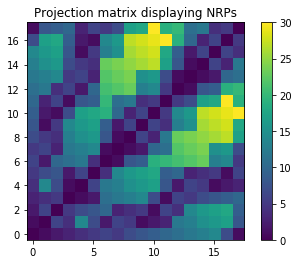

Non-redundant pairs (30):
[[ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 13]
 [ 1 14]
 [ 1 15]
 [ 1 16]
 [ 2 15]
 [ 2 16]
 [ 2 17]
 [ 3 17]
 [ 7 11]
 [ 7 12]
 [ 7 13]
 [ 7 14]
 [ 7 15]
 [ 8 15]
 [ 9 15]
 [ 9 16]
 [ 9 17]
 [10 17]
 [11 17]
 [11 18]]


In [15]:
#-# Import information form aperture generation script
Projection_Matrix = fits.getdata(os.path.join(dataDir, 'segmentation', 'Projection_Matrix.fits'))
vec_list = fits.getdata(os.path.join(dataDir, 'segmentation', 'vec_list.fits'))
NR_pairs_list = fits.getdata(os.path.join(dataDir, 'segmentation', 'NR_pairs_list_int.fits'))
NR_pairs_nb = NR_pairs_list.shape[0]
    
plt.imshow(Projection_Matrix[:,:,0], origin='lower')
plt.title('Projection matrix displaying NRPs')
plt.colorbar()
plt.show()
    
print('Non-redundant pairs (' + str(NR_pairs_nb) + '):')
print(NR_pairs_list)

### Calculating the (uncalibrated) analytical image

We don't have calibration coefficients yet, so we skip the "if cali:" part.

Move on to the calculation of eq. 13 in the paper Leboulleux et al. 2018 that calculates the image intensity of the analytical images:

$$I(u) = ||\hat{Z_l}(u)||^2  \Bigg[ \sum_{k=1}^{n_{seg}} a^2_{k,l} + 2 \sum_{q=1}^{n_{NRP}} A_q cos(b_q \cdot u) \Bigg] $$

#### Generic coefficients

$A_q$... *generic coefficients*

$$A_q = \sum_{(i,j)} a_{i,l} a_{j,l}$$

In [16]:
#-# Generic coefficients
generic_coef = np.zeros(NR_pairs_nb)   # coefficients in front of the non redundant pairs, the A_q in eq. 13 in Leboulleux et al. 2018

for q in range(NR_pairs_nb):
    for i in range(nb_seg):
        for j in range(i+1, nb_seg):
            if Projection_Matrix[i, j, 0] == q+1:
                print('q:', q, 'i:', i, 'j:', j)
                generic_coef[q] += coef[i] * coef[j]
                print('ci:', coef[i], 'cj:', coef[j])
                    

q: 0 i: 0 j: 1
ci: 94.4444444444 cj: -5.55555555556
q: 0 i: 0 j: 17
ci: 94.4444444444 cj: -5.55555555556
q: 0 i: 1 j: 9
ci: -5.55555555556 cj: -5.55555555556
q: 0 i: 2 j: 10
ci: -5.55555555556 cj: -5.55555555556
q: 0 i: 3 j: 4
ci: -5.55555555556 cj: -5.55555555556
q: 0 i: 3 j: 11
ci: -5.55555555556 cj: -5.55555555556
q: 0 i: 4 j: 15
ci: -5.55555555556 cj: -5.55555555556
q: 0 i: 5 j: 16
ci: -5.55555555556 cj: -5.55555555556
q: 0 i: 6 j: 7
ci: -5.55555555556 cj: -5.55555555556
q: 0 i: 7 j: 8
ci: -5.55555555556 cj: -5.55555555556
q: 0 i: 12 j: 13
ci: -5.55555555556 cj: -5.55555555556
q: 0 i: 13 j: 14
ci: -5.55555555556 cj: -5.55555555556
q: 1 i: 0 j: 2
ci: 94.4444444444 cj: -5.55555555556
q: 1 i: 1 j: 6
ci: -5.55555555556 cj: -5.55555555556
q: 1 i: 1 j: 10
ci: -5.55555555556 cj: -5.55555555556
q: 1 i: 3 j: 5
ci: -5.55555555556 cj: -5.55555555556
q: 1 i: 4 j: 12
ci: -5.55555555556 cj: -5.55555555556
q: 1 i: 4 j: 16
ci: -5.55555555556 cj: -5.55555555556
q: 1 i: 7 j: 9
ci: -5.55555555556 cj:

In [17]:
print('Generic coefficients:')
print(generic_coef)

Generic coefficients:
[-740.74074074 -308.64197531 -339.50617284 -308.64197531 -740.74074074
 -185.18518519 -864.19753086 -339.50617284 -370.37037037 -370.37037037
 -432.09876543 -370.37037037 -370.37037037 -339.50617284  123.45679012
  185.18518519  185.18518519  123.45679012   92.59259259   61.72839506
   30.86419753   61.72839506   92.59259259   61.72839506   30.86419753
   61.72839506   92.59259259   61.72839506   30.86419753   61.72839506]


#### Sum over the aberration coefficients and sum over the cosines

$cos(b_q \cdot u)$... cos_u_mat

Sum over $a^2_{k,l}$... sum1

In [18]:
#-# Constant sum and cosine sum - calculating eq. 13 from Leboulleux et al. 2018
i_line = np.linspace(-im_size_pastis/2., im_size_pastis/2., im_size_pastis)
tab_i, tab_j = np.meshgrid(i_line, i_line)
cos_u_mat = np.zeros((int(im_size_pastis), int(im_size_pastis), NR_pairs_nb))
    
# The -1 with each NR_pairs_list is because the segment names are saved starting from 1, but Python starts
# its indexing at zero, so we have to make it start at zero here too.
for q in range(NR_pairs_nb):
    cos_u_mat[:,:,q] = np.cos(px_sq_to_rad * (vec_list[NR_pairs_list[q,0]-1, NR_pairs_list[q,1]-1, 0] * tab_i) + 
                              px_sq_to_rad * (vec_list[NR_pairs_list[q,0]-1, NR_pairs_list[q,1]-1, 1] * tab_j))

sum1 = np.sum(coef**2)   # sum of all a_{k,l} in eq. 13 - this works only for single Zernikes (l fixed), because np.sum would sum over l too, which would be wrong.
    
print('cos:', cos_u_mat)
print('sum1:', sum1)

cos: [[[-0.98270038  0.93380899  0.44974419 ..., -0.27012805  0.73501224
    0.99997772]
  [-0.74177984  0.98331724  0.44974419 ...,  0.93907413 -0.97980968
   -0.08217993]
  [-0.28300178  0.74402948  0.44974419 ..., -0.82785082  0.41059521
   -0.98756432]
  ..., 
  [-0.26213732  0.72936618  0.44974419 ..., -0.87333625  0.48804727
   -0.97525414]
  [ 0.27977688  0.26537901  0.44974419 ...,  0.11535184  0.4228151
    0.2941121 ]
  [ 0.73952183 -0.27654882  0.44974419 ...,  0.73846523 -0.98240872
    0.93082808]]

 [[-0.87607931  0.8338969   0.98673234 ...,  0.35243459 -0.42748597
   -0.02012072]
  [-0.49590069  0.42352505  0.98673234 ...,  0.5532238  -0.48353663
   -0.99542236]
  [ 0.02992182 -0.11123427  0.98673234 ..., -0.99927175  0.99284389
    0.17048073]
  ..., 
  [ 0.05158946 -0.13275793  0.98673234 ..., -0.99220878  0.97876489
    0.23418071]
  [ 0.56498113 -0.63030735  0.98673234 ...,  0.68113121 -0.73850152
    0.95172969]
  [ 0.9124403  -0.94273823  0.98673234 ...,  0.1958204

$\Bigg[ \sum_{k=1}^{n_{seg}} a^2_{k,l} + 2 \sum_{q=1}^{n_{NRP}} A_q cos(b_q \cdot u) \Bigg]$ = sum2 + generic_coef[q] * cos_u_mat[:,:,q]

In [19]:
sum2 = np.zeros((int(im_size_pastis), int(im_size_pastis)))
for q in range(NR_pairs_nb):
    sum2 = sum2 + generic_coef[q] * cos_u_mat[:,:,q]
    
print('sum2:', sum2)

sum2: [[  701.51958558   352.31989611   113.17964044 ...,   113.17964044
    352.31989611   701.51958558]
 [  865.21594472  -344.87482613  -929.11438889 ...,  -929.11438889
   -344.87482613   865.21594472]
 [ -338.65089538  -990.72100816 -1258.52716664 ..., -1258.52716664
   -990.72100816  -338.65089537]
 ..., 
 [ -338.65089537  -990.72100816 -1258.52716664 ..., -1258.52716664
   -990.72100816  -338.65089538]
 [  865.21594472  -344.87482613  -929.11438889 ...,  -929.11438889
   -344.87482613   865.21594472]
 [  701.51958558   352.31989611   113.17964044 ...,   113.17964044
    352.31989611   701.51958558]]


#### The global envelope from the mini segment Zernike

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((239, 239), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


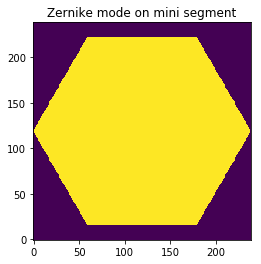

In [20]:
#-# Local Zernike
# Generate a basis of Zernikes with the mini segment being the support
isolated_zerns = zern.hexike_basis(nterms=zern_max, npix=size_seg, rho=None, theta=None, vertical=False, outside=0.0)

# Calculate the Zernike that is currently being used and put it on one single subaperture, the result is Zer
# Apply the currently used Zernike to the mini-segment.
if zernike_pol == 1:
    Zer = np.copy(mini_seg)
elif zernike_pol in range(2, zern_max-2):
    Zer = np.copy(mini_seg)
    Zer = Zer * isolated_zerns[zernike_pol-1]
    
plt.imshow(Zer, origin='lower')
plt.title('Zernike mode on mini segment')
plt.show()

Simply to show what it would look like for other Zernikes:

In [21]:
# Calculate them
zern_iter = np.arange(8) + 1   # +1 so that they start at 1
print('Zernike numbers (Noll):', zern_iter)

minizern_stack = []
for i in range(zern_iter.shape[0]):
    if i+1 == 1:    # for piston
        minizern_stack.append(mini_seg)
    elif i+1 in range(2, zern_max-2):
        minizern_stack.append(mini_seg * isolated_zerns[i])
        
minizern_stack = np.array(minizern_stack)

Zernike numbers (Noll): [1 2 3 4 5 6 7 8]


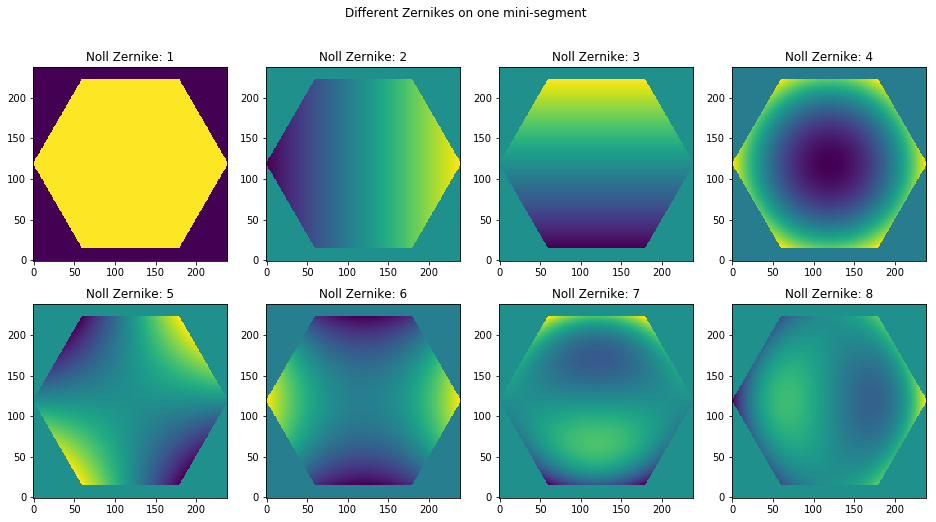

In [22]:
# Display them
plt.figure(figsize=(16, 8))
plt.suptitle('Different Zernikes on one mini-segment')
for i in range(minizern_stack.shape[0]):
    plt.subplot(2, 4, i+1)
    plt.imshow(minizern_stack[i], origin='lower')
    plt.title('Noll Zernike: ' + str(i+1))
plt.show()

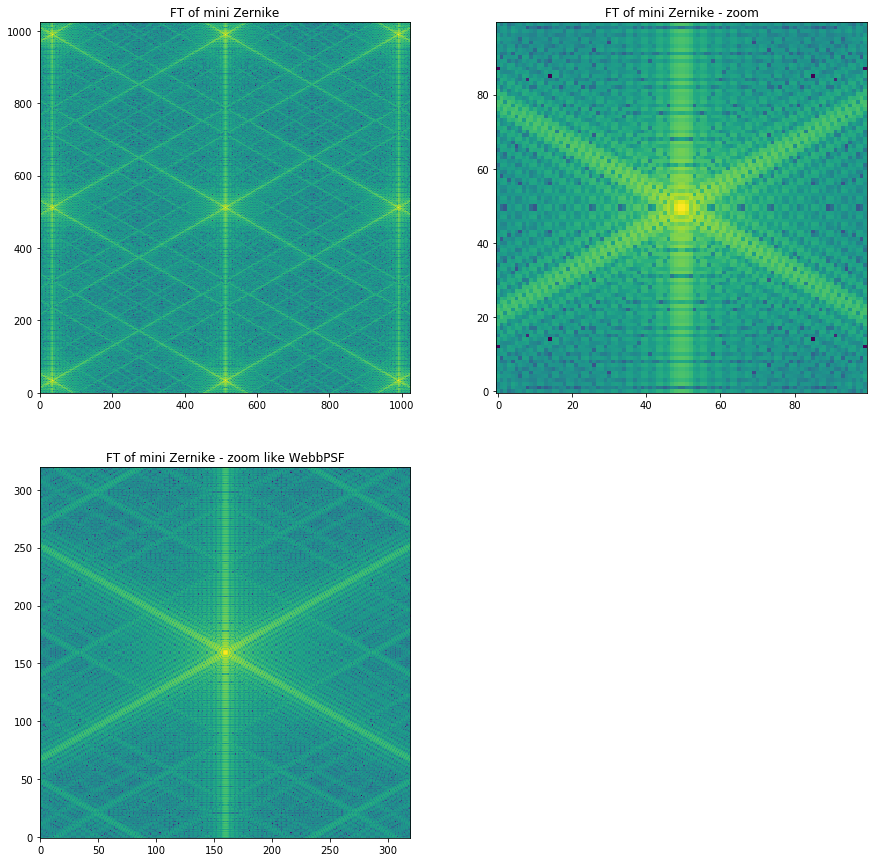

In [31]:
# Fourier Transform of the Zernike - the global envelope
mf = mft.MatrixFourierTransform()
ft_zern = mf.perform(Zer, im_size_pastis/sampling, im_size_pastis)

box_e2e = int(im_size_e2e/2)    # We set the image zoom to the same like WebbPSF

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.imshow(np.abs(ft_zern), norm=LogNorm(), origin='lower')
plt.title('FT of mini Zernike')
plt.subplot(2, 2, 2)
plt.imshow(zoom(np.abs(ft_zern), 50), norm=LogNorm(), origin='lower')
plt.title('FT of mini Zernike - zoom')
plt.subplot(2, 2, 3)
plt.imshow(zoom(np.abs(ft_zern), box_e2e), norm=LogNorm(), origin='lower')
plt.title('FT of mini Zernike - zoom like WebbPSF')
plt.show()

#### What do those envelopes look like for other Zernikes?

Also check the global envelopes from the other Zernikes on the mini-segment.

In [32]:
mini_ft = []
for i in range(minizern_stack.shape[0]):
    ft_klein = mf.perform(minizern_stack[i], im_size_pastis/sampling, im_size_pastis)
    mini_ft.append(ft_klein)
    
mini_ft = np.array(mini_ft)

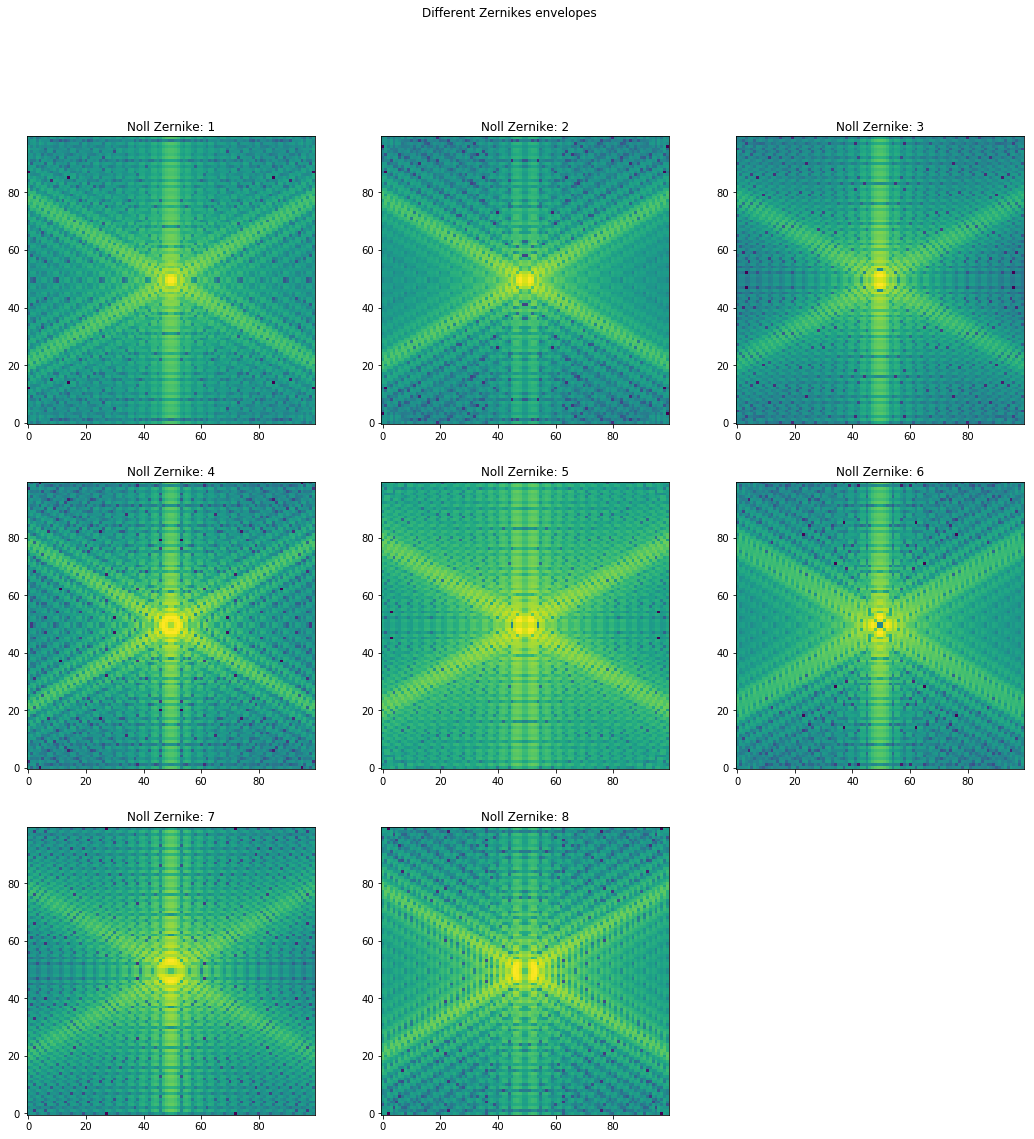

In [33]:
zoomin = 50

plt.figure(figsize=(18, 18))
plt.suptitle('Different Zernikes envelopes')
for i in range(mini_ft.shape[0]):
    plt.subplot(3, 3, i+1)
    plt.imshow(zoom(np.abs(mini_ft[i]), zoomin), norm=LogNorm(), origin='lower')
    plt.title('Noll Zernike: ' + str(i+1))
plt.show()

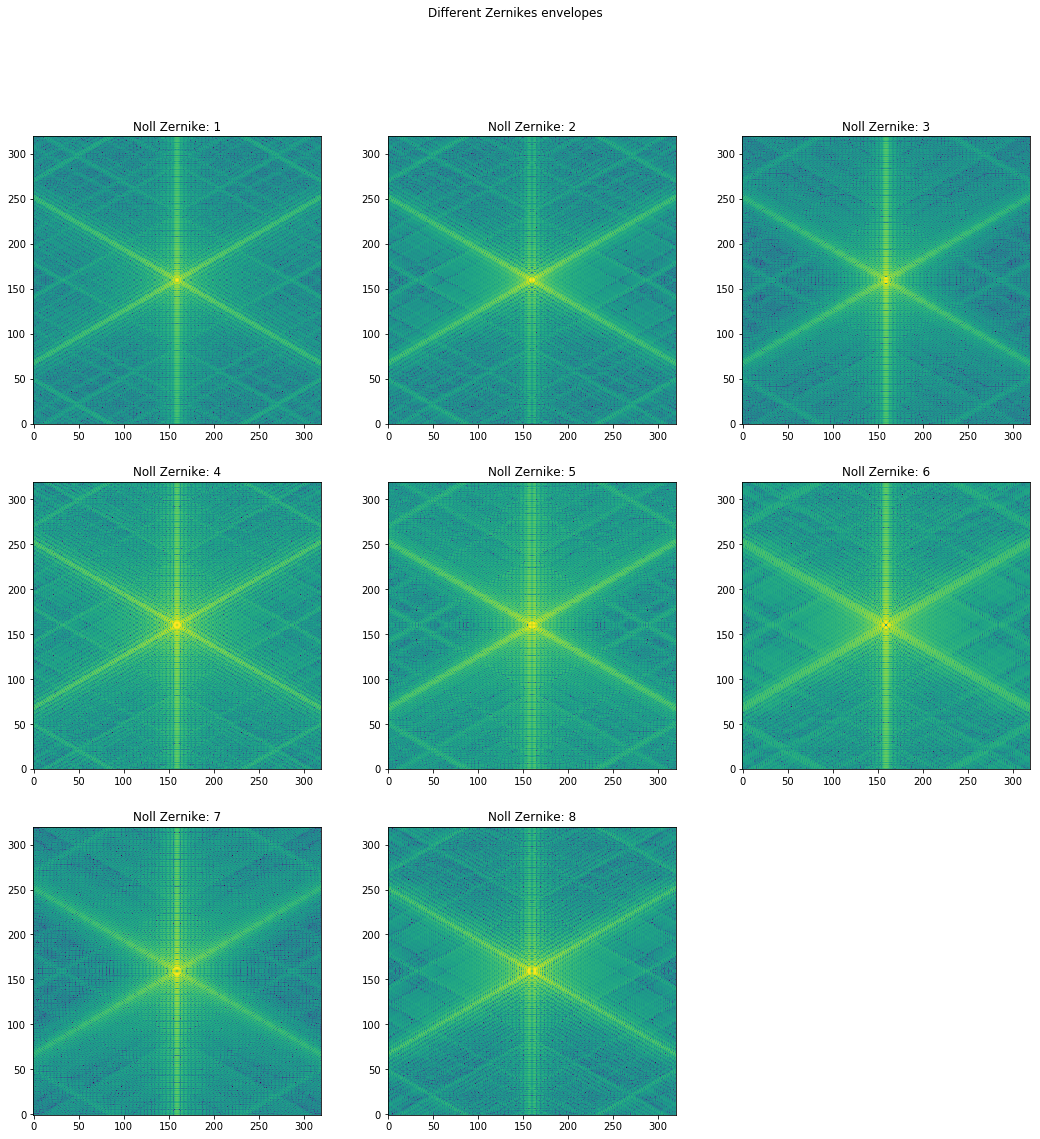

In [34]:
# Now in the image size of the WebbPSF images from 3. notebook
plt.figure(figsize=(18, 18))
plt.suptitle('Different Zernikes envelopes')
for i in range(mini_ft.shape[0]):
    plt.subplot(3, 3, i+1)
    plt.imshow(zoom(np.abs(mini_ft[i]), box_e2e), norm=LogNorm(), origin='lower')
    plt.title('Noll Zernike: ' + str(i+1))
plt.show()

They correspond to what Lucie has in her paper, which is pretty cool. The sampling is very different though, as I tried to match the sampling to the WebbPSF default.

#### Putting things together and calculating the full image

Moving on. Calculating the full $I(u)$ now.

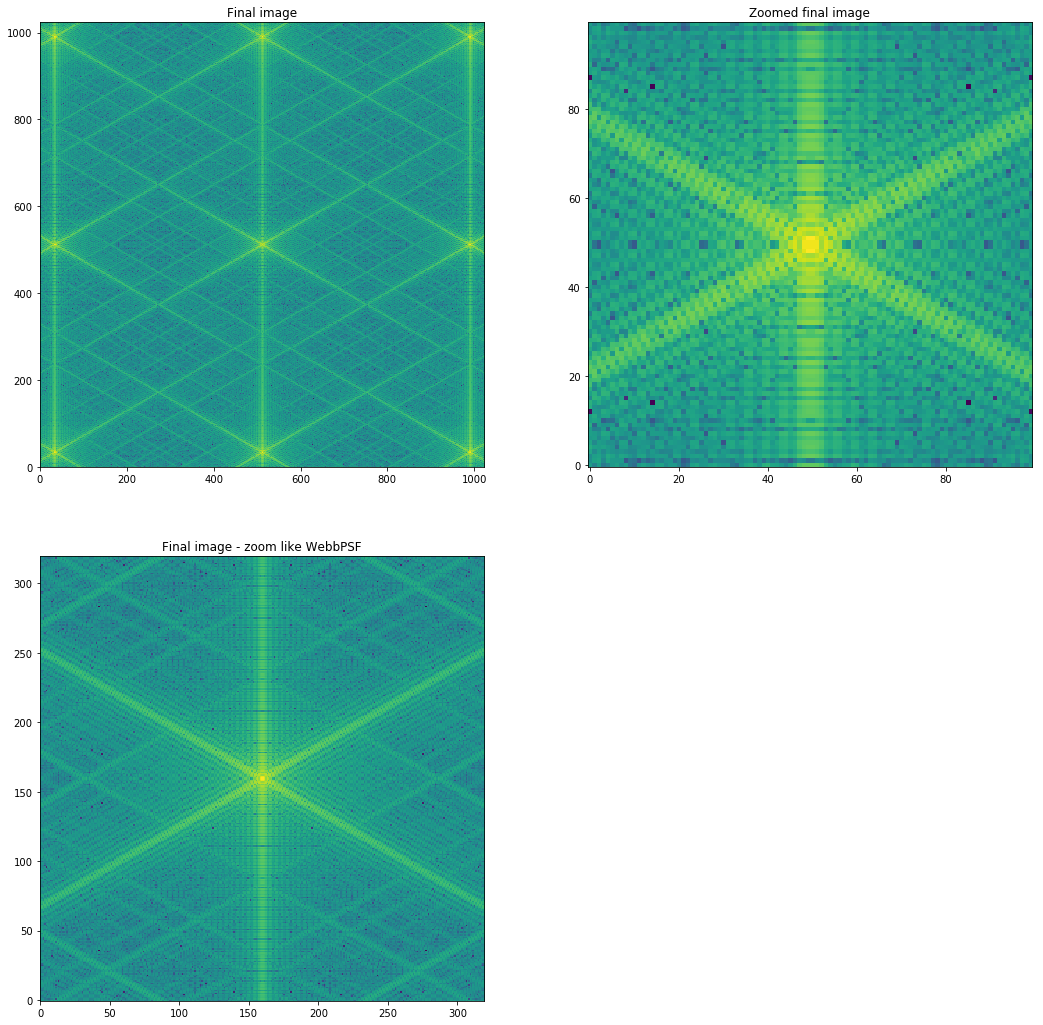

In [35]:
#-# Final image
# Generating the final image that will get passed on to the outer scope, I(u) in eq. 13
intensity = np.abs(ft_zern**2 * (sum1 + 2. * sum2))

plt.figure(figsize=(18,18))
plt.subplot(2, 2, 1)
plt.imshow(intensity, norm=LogNorm(), origin='lower')
plt.title('Final image')
plt.subplot(2, 2, 2)
plt.imshow(zoom(intensity, 50), norm=LogNorm(), origin='lower')   #[450:575, 450:575]
plt.title('Zoomed final image')
plt.subplot(2, 2, 3)
plt.imshow(zoom(np.abs(ft_zern), box_e2e), norm=LogNorm(), origin='lower')
plt.title('Final image - zoom like WebbPSF')
plt.show()



#### Extracting the dark hole

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


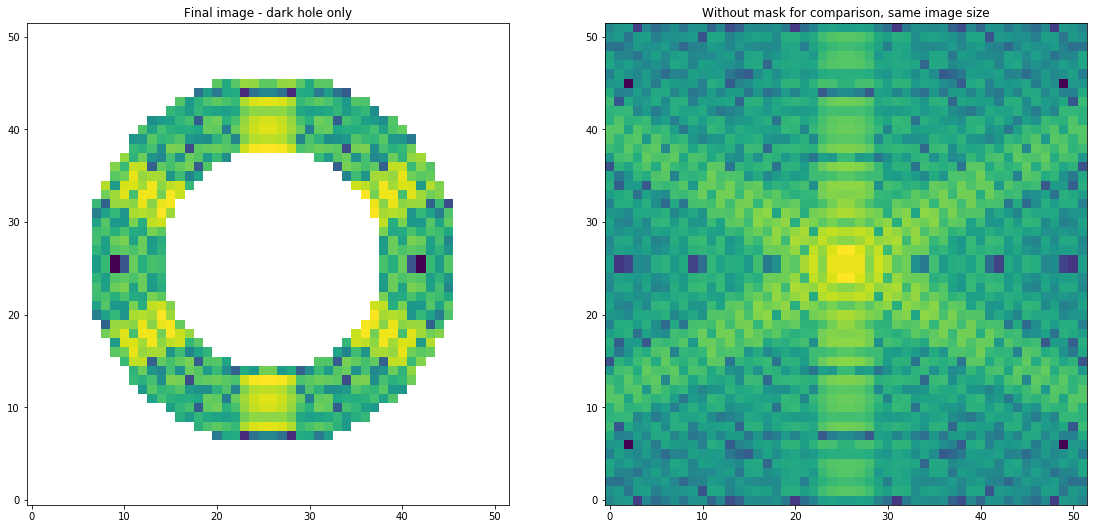

In [36]:
# PASTIS is only valid inside the dark hole.
tot_dh_im_size = sampling*(outer_wa+3)                     # zoom box must be big enough to capture entire DH

intensity_zoom = zoom(intensity, tot_dh_im_size)
dh_area_zoom = zoom(dh_area, tot_dh_im_size)

dh_psf = dh_area_zoom * intensity_zoom

# Display dark hole and inner part of image next ot each other, on the same scale
plt.figure(figsize=(19,10))
plt.subplot(1, 2, 1)
plt.imshow(dh_psf, norm=LogNorm(), origin='lower')
plt.title('Final image - dark hole only')
plt.subplot(1, 2, 2)
plt.imshow(zoom(intensity, tot_dh_im_size), norm=LogNorm(), origin='lower')
plt.title('Without mask for comparison, same image size')
plt.show()

Crop out the DH for the Zernike envelopes.

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


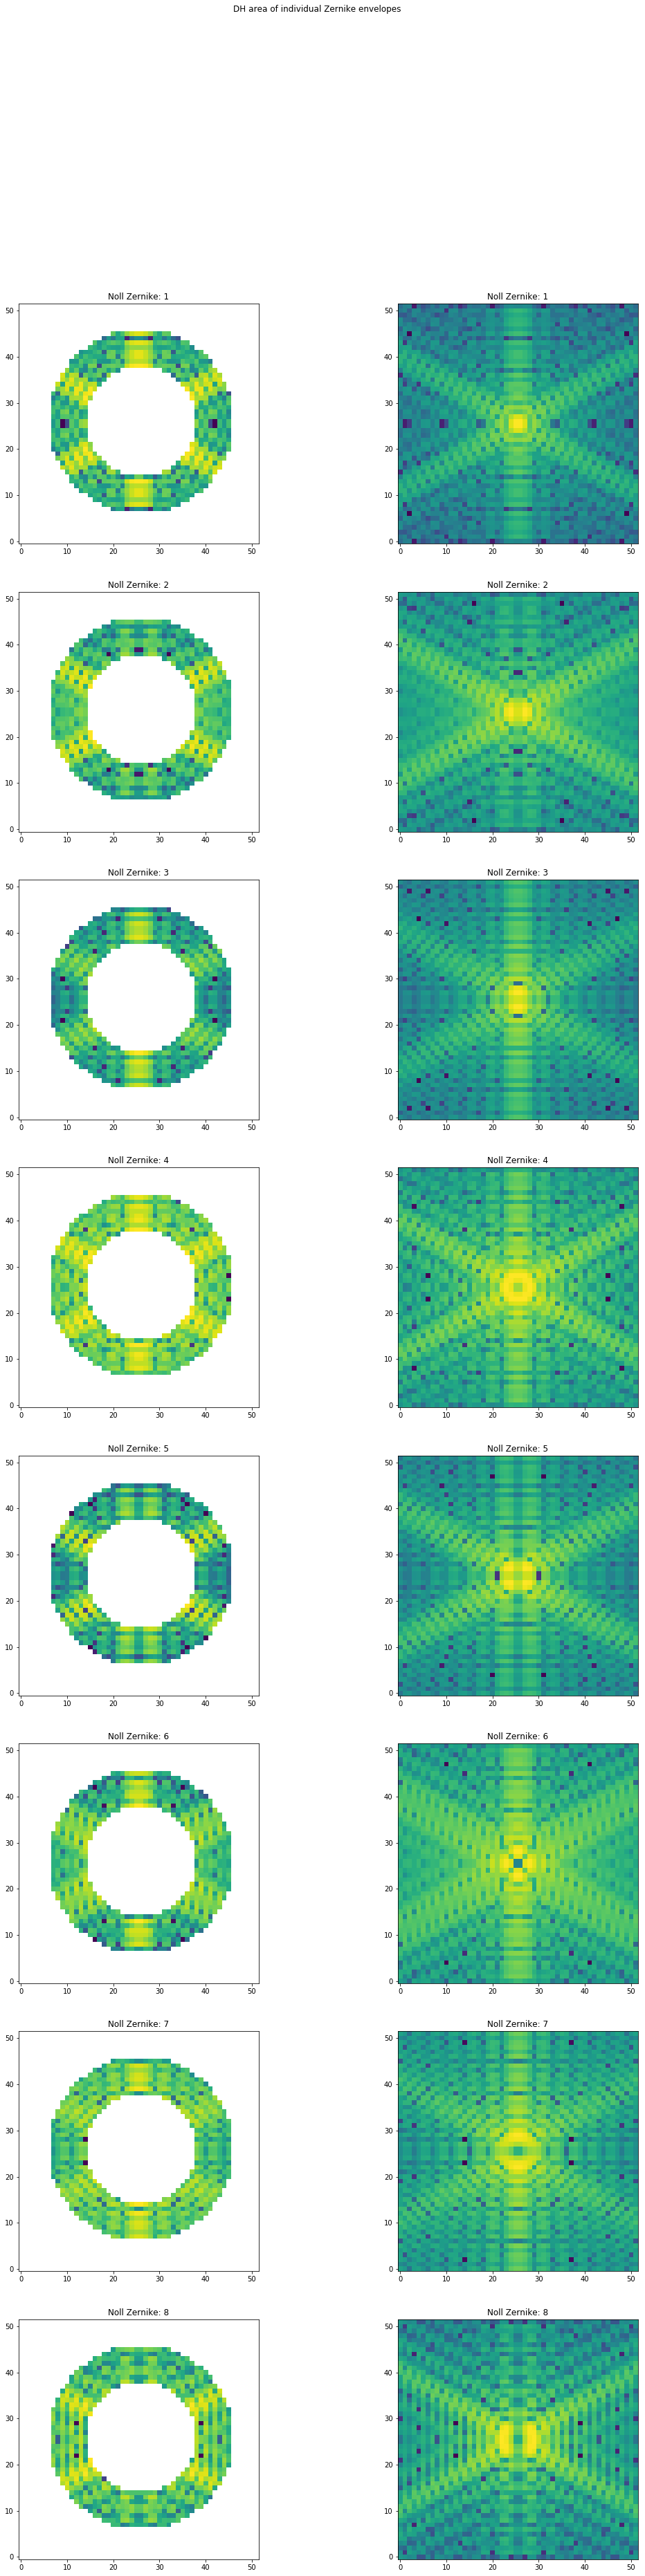

In [37]:
mini_im = np.abs(mini_ft)    # don't forget that mini_ft is the E-field
mini_dh_stack = []
plt.figure(figsize=(18, 60))
plt.suptitle('DH area of individual Zernike envelopes')
for i in range(mini_ft.shape[0]):
    mini_zoom = zoom(mini_im[i], tot_dh_im_size)
    mini_dh = dh_area_zoom * mini_zoom
    mini_dh_stack.append(mini_dh)
    
    plt.subplot(8, 2, i*2+1)
    plt.imshow(np.abs(mini_dh), norm=LogNorm(), origin='lower')
    plt.title('Noll Zernike: ' + str(i+1))
    
    plt.subplot(8, 2, i*2+2)
    plt.imshow(np.abs(mini_zoom), norm=LogNorm(), origin='lower')
    plt.title('Noll Zernike: ' + str(i+1))
    
plt.show()

### Aberrating pairs of segments

We now want to explore what the final analytical image looks like when we aberrate two segments at a time, with the same aberration.

In [38]:
# Decide which two segments you want to aberrate
segnum1 = 9     # Which segments are we aberrating - I number them starting with 1
segnum2 = 15

segnum_array = np.array([segnum1, segnum2])

zern_pair = 1  # Which Noll Zernike are we putting on the segments.

print('Aberrated segments:', segnum_array)
print('Noll Zernike used:', zern_pair)

# Create aberration vector
Aber_Noll = np.zeros([nb_seg, zern_max])
print('nm_aber:', nm_aber, 'nm')

# Fill aberration array
for i, nseg in enumerate(segnum_array):
    Aber_Noll[nseg-1, zern_pair-1] = nm_aber   # fill only the index for current Zernike, on segment i - in nm
    
# Define the aberration coefficient vector
coef = Aber_Noll[:, zern_pair-1]
#coef[:] = 1
print('coef:', coef)

Aberrated segments: [ 9 15]
Noll Zernike used: 1
nm_aber: 100.0 nm
coef: [   0.    0.    0.    0.    0.    0.    0.    0.  100.    0.    0.    0.
    0.    0.  100.    0.    0.    0.]


In [39]:
#-# Generic coefficients
generic_coef = np.zeros(NR_pairs_nb)   # coefficients in front of the non redundant pairs, the A_q in eq. 13 in Leboulleux et al. 2018

for q in range(NR_pairs_nb):
    for i in range(nb_seg):
        for j in range(i+1, nb_seg):
            if Projection_Matrix[i, j, 0] == q+1:
                generic_coef[q] += coef[i] * coef[j]
                
print('Generic coefficients:')
print(generic_coef)

#-# Constant sum and cosine sum - calculating eq. 13 from Leboulleux et al. 2018
i_line = np.linspace(-im_size_pastis/2., im_size_pastis/2., im_size_pastis)
tab_i, tab_j = np.meshgrid(i_line, i_line)   # these are arrys for the image plane coordinate u
cos_u_mat = np.zeros((int(im_size_pastis), int(im_size_pastis), NR_pairs_nb))
    
# The -1 with each NR_pairs_list is because the segment names are saved starting from 1, but Python starts
# its indexing at zero, so we have to make it start at zero here too.
for q in range(NR_pairs_nb):
    cos_u_mat[:,:,q] = np.cos(px_sq_to_rad * (vec_list[NR_pairs_list[q,0]-1, NR_pairs_list[q,1]-1, 0] * tab_i) + 
                              px_sq_to_rad * (vec_list[NR_pairs_list[q,0]-1, NR_pairs_list[q,1]-1, 1] * tab_j))

sum1 = np.sum(coef**2)   # sum of all a_{k,l} in eq. 13 - this works only for single Zernikes (l fixed), because np.sum would sum over l too, which would be wrong.
    
#print('cos:', cos_u_mat)
#print('sum1:', sum1)

sum2 = np.zeros((int(im_size_pastis), int(im_size_pastis)))
for q in range(NR_pairs_nb):
    sum2 = sum2 + generic_coef[q] * cos_u_mat[:,:,q]
    
#print('sum2:', sum2)

Generic coefficients:
[     0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.      0.      0.      0.  10000.      0.      0.
      0.      0.      0.]


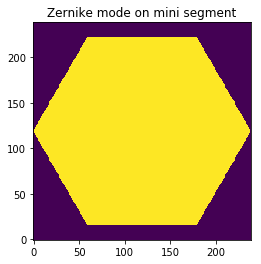

In [40]:
# Calculate the Zernike that is currently being used and put it on one single subaperture, the result is Zer
# Apply the currently used Zernike to the mini-segment.
if zern_pair == 1:
    Zer = np.copy(mini_seg)
elif zern_pair in range(2, zern_max-2):
    Zer = np.copy(mini_seg)
    Zer = Zer * isolated_zerns[zern_pair-1]
    
plt.imshow(Zer, origin='lower')
plt.title('Zernike mode on mini segment')
plt.show()

In [41]:
# Fourier Transform of the Zernike - the global envelope
mf = mft.MatrixFourierTransform()
ft_zern = mf.perform(Zer, im_size_pastis/sampling, im_size_pastis)

#xcen = int(ft_zern.shape[1]/2.)
#ycen = int(ft_zern.shape[0]/2.)
#boxw = int(161/2)    # We can see in the 3. notebook that WebbPSF produces 161 x 161 px images by default.
#
#plt.figure(figsize=(15, 15))
#plt.subplot(2, 2, 1)
#plt.imshow(np.abs(ft_zern), norm=LogNorm())
#plt.title('FT of mini Zernike')
#plt.subplot(2, 2, 2)
#plt.imshow(np.abs(ft_zern)[485:540, 485:540], norm=LogNorm())
#plt.title('FT of mini Zernike - zoom')
#plt.subplot(2, 2, 3)
#plt.imshow(np.abs(ft_zern)[ycen-boxw:ycen+boxw, xcen-boxw:xcen+boxw], norm=LogNorm())
#plt.title('FT of mini Zernike - zoom like WebbPSF')
#plt.show()

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


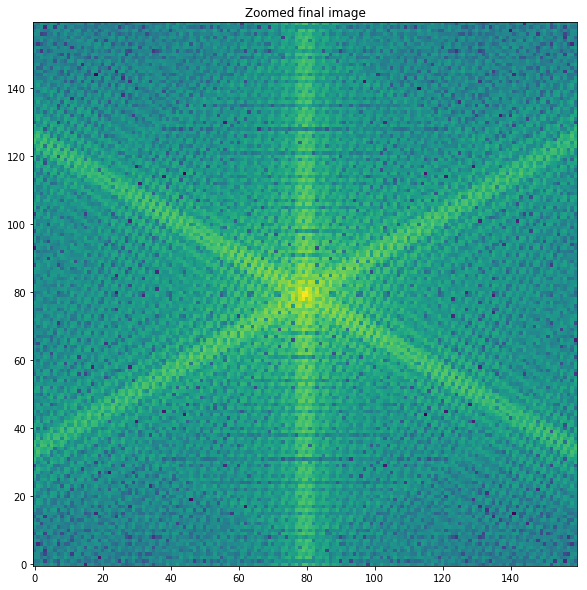

In [44]:
#-# Final image
# Generating the final image that will get passed on to the outer scope, I(u) in eq. 13
intensity = np.abs(ft_zern**2 * (sum1 + 2. * sum2))

boxw2 = box_e2e/2

plt.figure(figsize=(10,10))
plt.imshow(zoom(intensity, boxw2), norm=LogNorm(), origin='lower')
plt.title('Zoomed final image')
plt.show()

#### Saving some of the images

I will save a couple of images down here to be able to display them next to each other:

In [82]:
#segs_3_11_noll_1 = np.copy(intensity)
#segs_11_17_noll_1 = np.copy(intensity)
#segs_6_11_noll_1 = np.copy(intensity)
#segs_9_2_noll_1 = np.copy(intensity)
#segs_9_5_noll_1 = np.copy(intensity)
#segs_9_15_noll_1 = np.copy(intensity)
#segs_8_2_noll_1 = np.copy(intensity)
#segs_8_3_noll_1 = np.copy(intensity)
#segs_8_12_noll_1 = np.copy(intensity)
#segs_8_18_noll_1 = np.copy(intensity)
#segs_2_6_noll_1 = np.copy(intensity)
#segs_10_16_noll_1 = np.copy(intensity)
#segs_8_1_noll_1 = np.copy(intensity)
#segs_8_6_noll_1 = np.copy(intensity)
#segs_8_16_noll_1 = np.copy(intensity)

#segs_10_16_noll_2 = np.copy(intensity)
#segs_2_6_noll_2 = np.copy(intensity)
#segs_8_18_noll_2 = np.copy(intensity)
#segs_8_12_noll_2 = np.copy(intensity)
#segs_8_3_noll_2 = np.copy(intensity)
#segs_8_2_noll_2 = np.copy(intensity)
#segs_9_15_noll_2 = np.copy(intensity)
#segs_9_2_noll_2 = np.copy(intensity)

In [83]:
# Save them all to fits files
save_dir = '/astro/opticslab1/PASTIS/jwst_data/uncalibrated_analytical_images/2018-01-25-16h-00min'
#util.write_fits(segs_3_11_noll_1, os.path.join(save_dir, 'segs_3_11_noll_1.fits'))
#util.write_fits(segs_11_17_noll_1, os.path.join(save_dir, 'segs_11_17_noll_1.fits'))
#util.write_fits(segs_6_11_noll_1, os.path.join(save_dir, 'segs_6_11_noll_1.fits'))
#util.write_fits(segs_9_2_noll_1, os.path.join(save_dir, 'segs_9_2_noll_1.fits'))
#util.write_fits(segs_9_5_noll_1, os.path.join(save_dir, 'segs_9_5_noll_1.fits'))
#util.write_fits(segs_9_15_noll_1, os.path.join(save_dir, 'segs_9_15_noll_1.fits'))
#util.write_fits(segs_8_2_noll_1, os.path.join(save_dir, 'segs_8_2_noll_1.fits'))
#util.write_fits(segs_8_3_noll_1, os.path.join(save_dir, 'segs_8_3_noll_1.fits'))
#util.write_fits(segs_8_12_noll_1, os.path.join(save_dir, 'segs_8_12_noll_1.fits'))
#util.write_fits(segs_8_18_noll_1, os.path.join(save_dir, 'segs_8_18_noll_1.fits'))
#util.write_fits(segs_2_6_noll_1, os.path.join(save_dir, 'segs_2_6_noll_1.fits'))
#util.write_fits(segs_10_16_noll_1, os.path.join(save_dir, 'segs_10_16_noll_1.fits'))
#util.write_fits(segs_8_1_noll_1, os.path.join(save_dir, 'segs_8_1_noll_1.fits'))
#util.write_fits(segs_8_6_noll_1, os.path.join(save_dir, 'segs_8_6_noll_1.fits'))
#util.write_fits(segs_8_16_noll_1, os.path.join(save_dir, 'segs_8_16_noll_1.fits'))

#util.write_fits(segs_10_16_noll_2, os.path.join(save_dir, 'segs_10_16_noll_2.fits'))
#util.write_fits(segs_2_6_noll_2, os.path.join(save_dir, 'segs_2_6_noll_2.fits'))
#util.write_fits(segs_8_18_noll_2, os.path.join(save_dir, 'segs_8_18_noll_2.fits'))
#util.write_fits(segs_8_12_noll_2, os.path.join(save_dir, 'segs_8_12_noll_2.fits'))
#util.write_fits(segs_8_3_noll_2, os.path.join(save_dir, 'segs_8_3_noll_2.fits'))
#util.write_fits(segs_8_2_noll_2, os.path.join(save_dir, 'segs_8_2_noll_2.fits'))
#util.write_fits(segs_9_15_noll_2, os.path.join(save_dir, 'segs_9_15_noll_2.fits'))
#util.write_fits(segs_9_2_noll_2, os.path.join(save_dir, 'segs_9_2_noll_2.fits'))

'/astro/opticslab1/PASTIS/jwst_data/uncalibrated_analytical_images/2018-01-25-16h-00min/segs_9_15_noll_1.fits'

#### Display and compare the images

I started making PASTIS images from the direct entrance pupil of JWST, which I needed to change to be using the exit pupil instead, because I needed to make it the same like in WebbPSF. That's what's happening now in the code, but below here, I am just showing the general properties of PASTIS images. I have made a lot more different data with the entrance pupil, which is why I am using those images for the demo below here. This data is stored in: '/astro/opticslab1/PASTIS/jwst_data/uncalibrated_analytical_images/2018-01-17-17h-35min_piston_pairs'.

#### *Fringe orientation and spacing*

Let's start with the image in which we put **piston** on **segments 3 and 11**. When we check in what relation those two segments lie to each other on the (exit!) pupil (open the pupil image file for help), we can see:

1. They like on a diagonal offset to each other, about 40 degrees tilted from the horizontal.
2. They are very close together, the closest two segments on the JWST can be.

This means for the image:
1. The fringes are are tilted by the same amount like the connection vector between the two segments, but flipped by 90 degrees.
2. Since the segments are **close together**, the fringes in the Fourier plane, here the final image, will be **wide**.

In [46]:
# I need to read the images in now
read_dir1 = '/astro/opticslab1/PASTIS/jwst_data/uncalibrated_analytical_images/2018-01-17-17h-35min_piston_1000nm_pairs'
segs_3_11_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_3_11_noll_1.fits'))
segs_11_17_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_11_17_noll_1.fits'))
segs_6_11_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_6_11_noll_1.fits'))
segs_9_2_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_9_2_noll_1.fits'))
segs_9_5_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_9_5_noll_1.fits'))
segs_9_15_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_9_15_noll_1.fits'))
segs_8_2_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_8_2_noll_1.fits'))
segs_8_3_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_8_3_noll_1.fits'))
segs_8_12_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_8_12_noll_1.fits'))
segs_8_18_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_8_18_noll_1.fits'))
segs_2_6_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_2_6_noll_1.fits'))
segs_10_16_noll_1 = fits.getdata(os.path.join(read_dir1, 'segs_10_16_noll_1.fits'))

read_dir2 = '/astro/opticslab1/PASTIS/jwst_data/uncalibrated_analytical_images/2018-01-17-17h-45min_tip_1000nm_pairs'
segs_10_16_noll_2 = fits.getdata(os.path.join(read_dir2, 'segs_10_16_noll_2.fits'))
segs_2_6_noll_2 = fits.getdata(os.path.join(read_dir2, 'segs_2_6_noll_2.fits'))
segs_8_18_noll_2 = fits.getdata(os.path.join(read_dir2, 'segs_8_18_noll_2.fits'))
segs_8_12_noll_2 = fits.getdata(os.path.join(read_dir2, 'segs_8_12_noll_2.fits'))
segs_8_3_noll_2 = fits.getdata(os.path.join(read_dir2, 'segs_8_3_noll_2.fits'))
segs_8_2_noll_2 = fits.getdata(os.path.join(read_dir2, 'segs_8_2_noll_2.fits'))
segs_9_15_noll_2 = fits.getdata(os.path.join(read_dir2, 'segs_9_15_noll_2.fits'))
segs_9_2_noll_2 = fits.getdata(os.path.join(read_dir2, 'segs_9_2_noll_2.fits'))

boxw2 = box_e2e/2

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


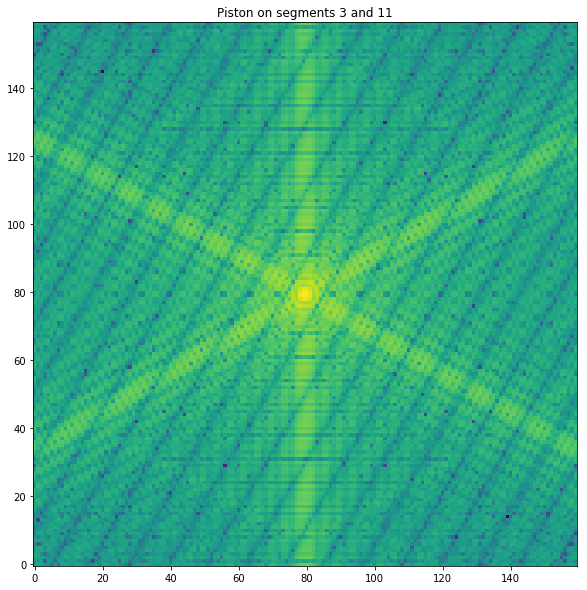

In [47]:
plt.figure(figsize=(10, 10))
plt.imshow(zoom(segs_3_11_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 3 and 11')
plt.show()

Moving on to the image iwhere we put **piston** on **segments 11 and 17**. As opposed to the previous image of segments 3 and 11 being aberrated:

1. They are connected by the same diagonal.
2. They are very far apart, they have the largest possible segment distance on the JWST.

This means for the image:
1. The fringes have the same orientation in the image like the previous one, because the two segment pairs have the same orientation.
2. Since the segments are **far apart**, the fringes in the Fourier plane, here the final image, will be **narrow**. In fact the fringes are so narrow, that we cannot clearly see them when the sampling is low (aliasing).

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


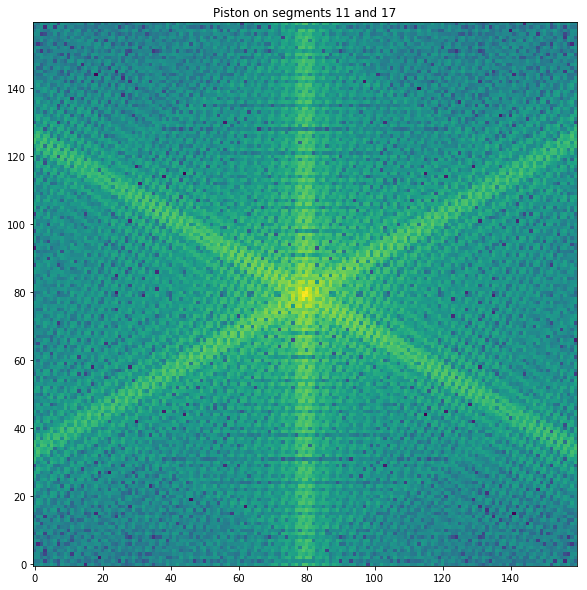

In [48]:
plt.figure(figsize=(10, 10))
plt.imshow(zoom(segs_11_17_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 11 and 17')
plt.show()

For **piston** on **segments 6 and 11**, we have the same fringe orientation again, because the segment pair has the same orientation in the pupil like the two examples before, but because their distance is in between the two previous cases, the fringe spacing will also be somewhere in between.

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


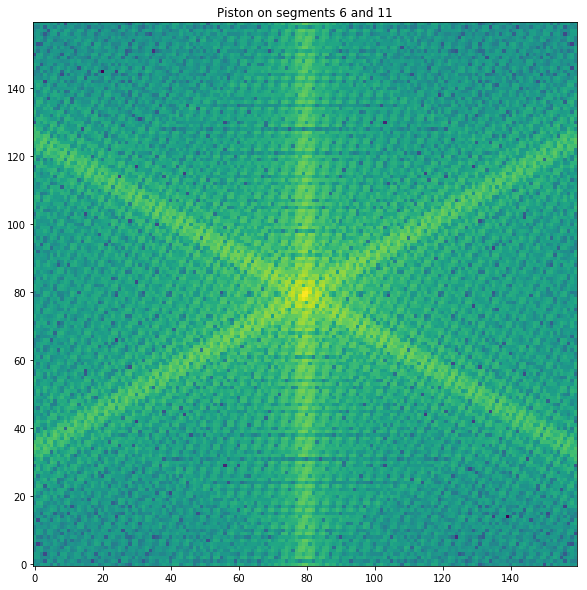

In [50]:
plt.figure(figsize=(10, 10))
plt.imshow(zoom(segs_6_11_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 6 and 11')
plt.show()

For **piston** on the segment pairs **9-2**, **9-5** and **9-15**, we can see that they have a pair orientation that is rotated by 90 degrees with respect to the cases we have looked at before, and since these three pairs have different segment separations, you can see how their fringe spacing differs.

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


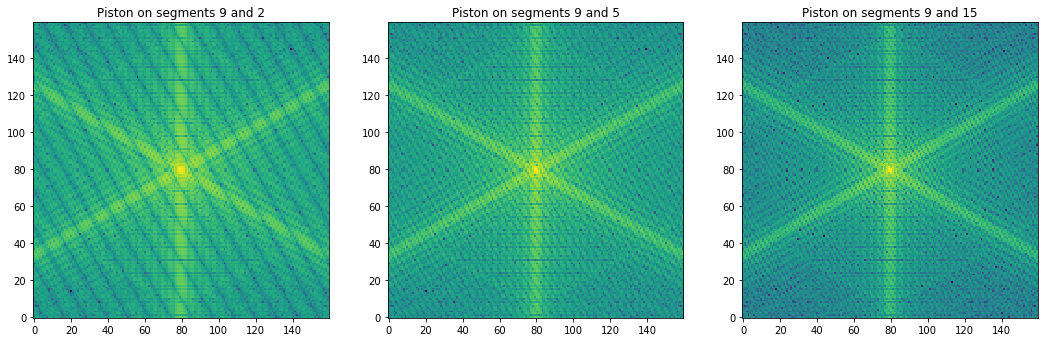

In [51]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(zoom(segs_9_2_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 9 and 2')

plt.subplot(1, 3, 2)
plt.imshow(zoom(segs_9_5_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 9 and 5')

plt.subplot(1, 3, 3)
plt.imshow(zoom(segs_9_15_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 9 and 15')

plt.show()

For **piston** on the segment pairs **8-2**, **8-3** and **8-12**, we can see that they have a pair orientation that is vertical in the pupil plane, so our fringes will be horizontal this time. And since these three pairs have different segment separations, you can see how their fringe spacing differs - like in the previous examples.

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


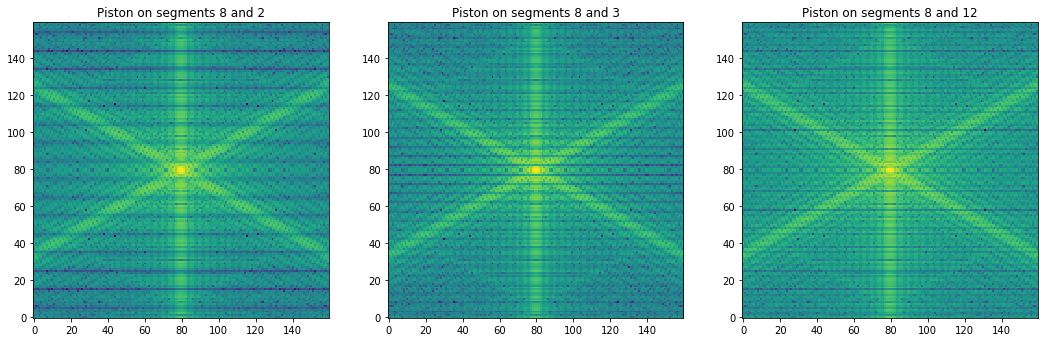

In [52]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(zoom(segs_8_2_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 8 and 2')

plt.subplot(1, 3, 2)
plt.imshow(zoom(segs_8_3_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 8 and 3')

plt.subplot(1, 3, 3)
plt.imshow(zoom(segs_8_12_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 8 and 12')

plt.show()

#### *Pair redundancy*

Below, I will display the images for **piston** on pair **8-18** and **2-6**.

As you can see - there is absolutely no difference. Except that we know that the two images come from a practically different setup, but effectively, they show the same result.
This is explained in Fig. 2 and Sec. 2.2.2 of Leboulleux et al. (2018). The only defining parameters for the influence a segment pair has on the image plane are its orientation and separation. Both of these things are exactly the same for the two pairs displayed here, hence the images resulting from these two seemingly different setups are the same.

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


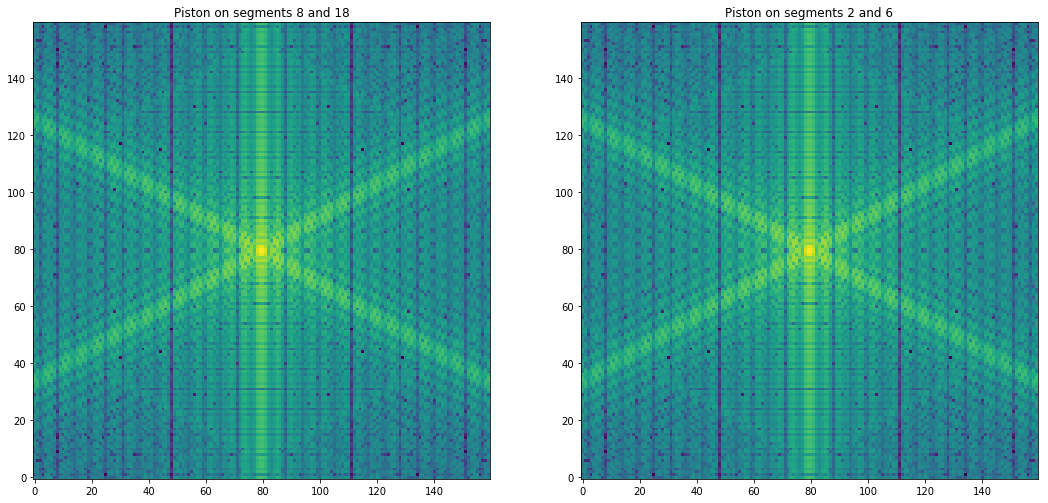

In [53]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.imshow(zoom(segs_8_18_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 8 and 18')

plt.subplot(1, 2, 2)
plt.imshow(zoom(segs_2_6_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 2 and 6')

plt.show()

And as one last example with **piston** only: pair **10-16**. The fringe orientation will be same like in the previous example, but the spacing will be different, because this pair is further apart.

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


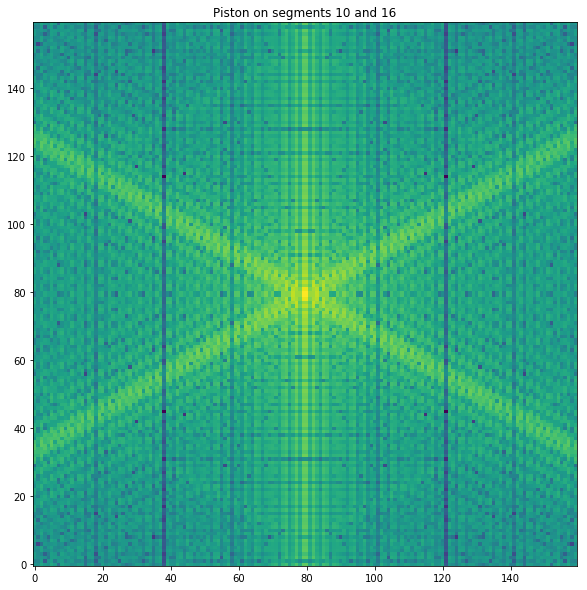

In [54]:
plt.figure(figsize=(10, 10))
plt.imshow(zoom(segs_10_16_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 10 and 16')
plt.show()

#### *A different Zernike than piston*

The principles described above will hold true for whatever Zernike we use to aberrate a segment pair. the morphology of the image will change with the chosen Zernike though, as we have see further above when we displayed the different envelopes coming from local Zernikes on the mini segment.

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


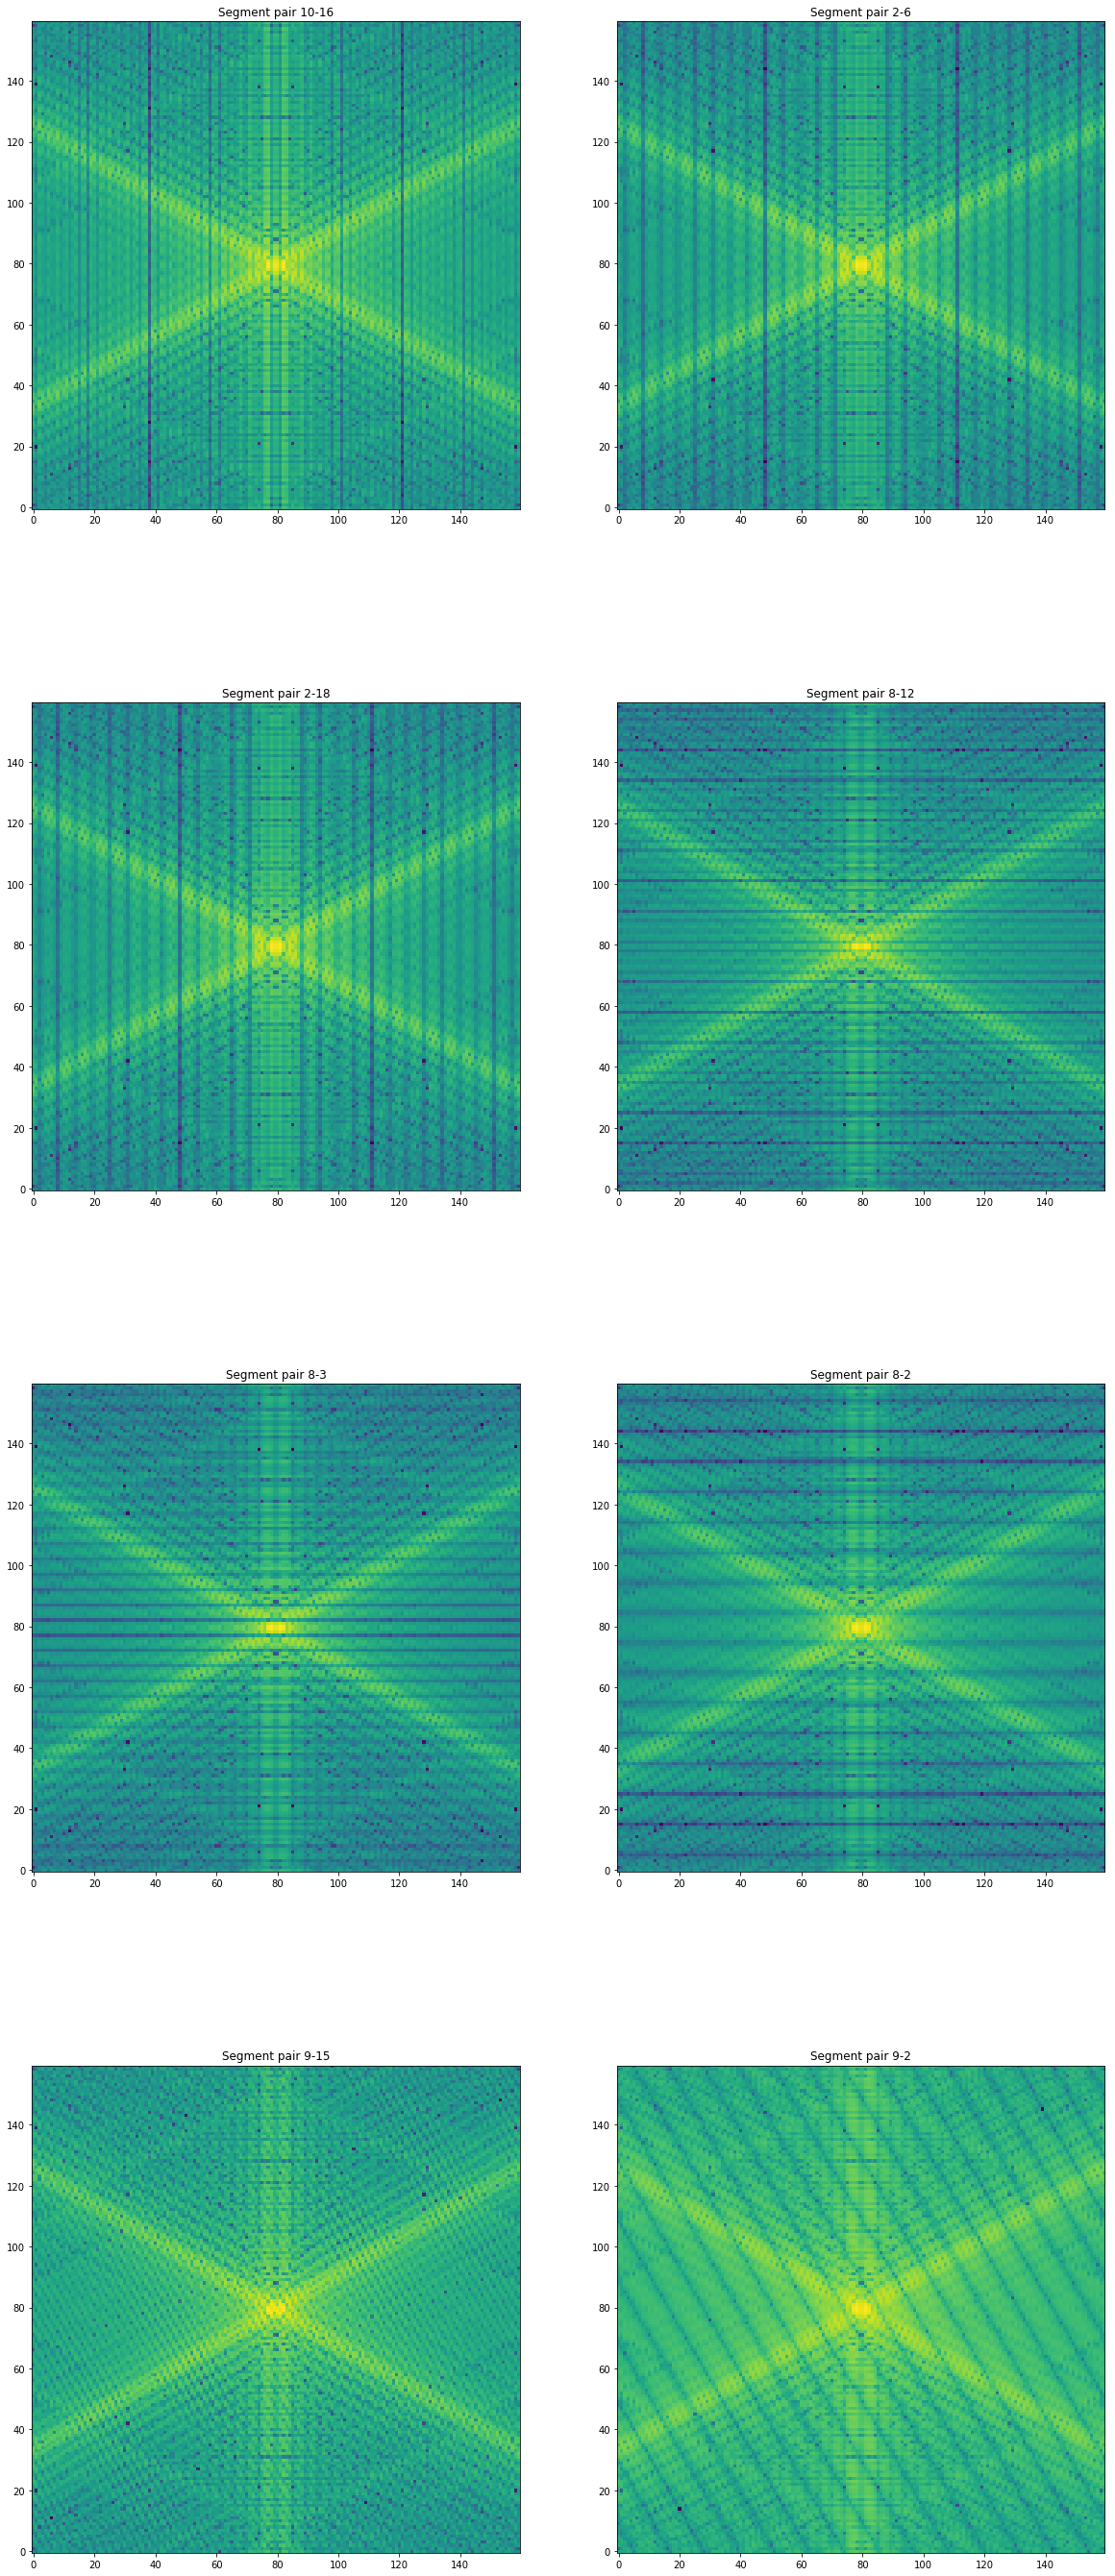

In [55]:
im_list2 = np.array([segs_10_16_noll_2, segs_2_6_noll_2, segs_8_18_noll_2, segs_8_12_noll_2, \
                    segs_8_3_noll_2, segs_8_2_noll_2, segs_9_15_noll_2, segs_9_2_noll_2])
pair_list2 = np.array(['10-16', '2-6', '2-18', '8-12', '8-3', '8-2', '9-15', '9-2'])

plt.figure(figsize=(20, 50))
for i in range(im_list2.shape[0]):
    plt.subplot(4, 2, i+1)
    plt.imshow(zoom(im_list2[i], boxw2), norm=LogNorm(), origin='lower')
    plt.title('Segment pair ' + pair_list2[i])

plt.show()

If we compare the pair **9-2** between the **piston** and the **tip** version, we can see that especially the core loos different. And there is that extra dark vertical line in the tip image, although it would be much easier to spot with increased image sampling.

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if sys.path[0] == '':


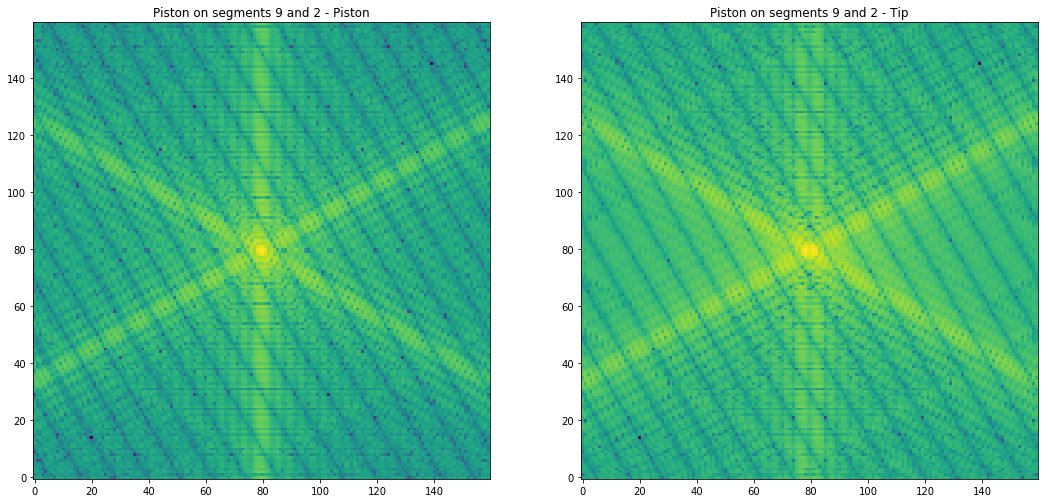

In [56]:
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.imshow(zoom(segs_9_2_noll_1, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 9 and 2 - Piston')

plt.subplot(1, 2, 2)
plt.imshow(zoom(segs_9_2_noll_2, boxw2), norm=LogNorm(), origin='lower')
plt.title('Piston on segments 9 and 2 - Tip')

plt.show()